In [1]:
# Import necessary libraries
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from itertools import product
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,Conv1D,Activation,Flatten,Dropout,MaxPooling1D

In [2]:
# Set the path to the data directory
PATH = os.path.join('numbers_data')

# Create an array of actions (signs) labels by listing the contents of the data directory
actions = np.array(os.listdir(PATH))

In [3]:
actions

array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U2')

In [4]:
# Define the number of sequences and frames
sequences = 30
frames = 40


In [5]:
# Create a label map to map each action label to a numeric value
label_map = {label:num for num, label in enumerate(actions)}

In [6]:
label_map

{'1': 0,
 '10': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [7]:
# Initialize empty lists to store landmarks and labels
landmarks, labels = [], []

# Iterate over actions and sequences to load landmarks and corresponding labels
for action, sequence in product(actions, range(sequences)):
    temp = []
    for frame in range(frames):
        npy = np.load(os.path.join(PATH, action, str(sequence), str(frame) + '.npy'))
        temp.append(npy)
    landmarks.append(temp)
    labels.append(label_map[action])

In [8]:
# Convert landmarks and labels to numpy arrays
X, Y = np.array(landmarks), to_categorical(labels).astype(int)
#Y is not one hot encoded

In [9]:
#Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=34, stratify=Y)

In [10]:
X_train.shape

(270, 40, 225)

In [11]:
actions.shape[0]

10

In [25]:
# Define the model architecture
model = Sequential()
# model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(frames,225)))
model.add(Conv1D(32, 3, padding='same', input_shape=(frames,225)))
model.add(Activation('relu'))
model.add(Conv1D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2))) 
model.add(Dropout(0.25))

model.add(Conv1D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

# Recurrent layers to integrate temporal information
model.add(GRU(64, return_sequences=True))  
model.add(GRU(32, return_sequences=False))

# Fully-connected layers    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
# model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [26]:
# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, Y_train, epochs=200)

Epoch 1/200
9/9 [==============================] - 5s 14ms/step - loss: 2.3186 - categorical_accuracy: 0.0963
Epoch 2/200
9/9 [==============================] - 0s 14ms/step - loss: 2.2471 - categorical_accuracy: 0.1444
Epoch 3/200
9/9 [==============================] - 0s 15ms/step - loss: 2.0860 - categorical_accuracy: 0.1889
Epoch 4/200
9/9 [==============================] - 0s 15ms/step - loss: 1.9556 - categorical_accuracy: 0.2000
Epoch 5/200
9/9 [==============================] - 0s 17ms/step - loss: 1.8889 - categorical_accuracy: 0.2296
Epoch 6/200
9/9 [==============================] - 0s 16ms/step - loss: 1.8317 - categorical_accuracy: 0.2444
Epoch 7/200
9/9 [==============================] - 0s 16ms/step - loss: 1.8297 - categorical_accuracy: 0.2074
Epoch 8/200
9/9 [==============================] - 0s 15ms/step - loss: 1.7718 - categorical_accuracy: 0.2370
Epoch 9/200
9/9 [==============================] - 0s 15ms/step - loss: 1.7704 - categorical_accuracy: 0.2148
Epoch 10/2

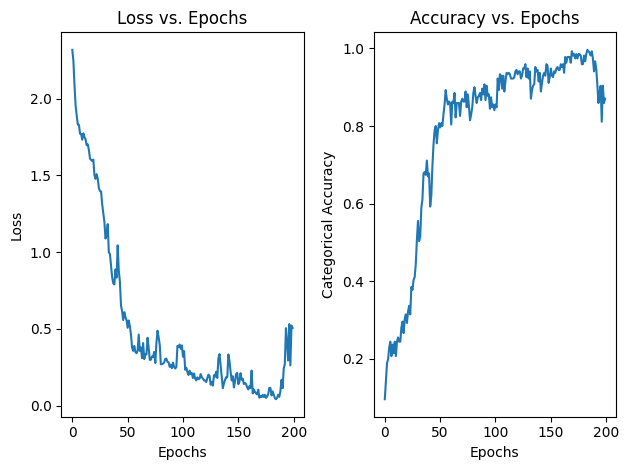

In [28]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")

# Subplot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.title("Accuracy vs. Epochs")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [29]:
#Save the trained model 
model.save('numbers_model')

INFO:tensorflow:Assets written to: numbers_model\assets


INFO:tensorflow:Assets written to: numbers_model\assets


In [30]:
# Make predictions on the test set
predictions = np.argmax(model.predict(X_test), axis=1)
# Get the true labels from the test set
test_labels = np.argmax(Y_test, axis=1)

# Calculate the accuracy of the predictions
accuracy = metrics.accuracy_score(test_labels, predictions)


1/1 [==============================] - 1s 552ms/step


In [31]:
predictions

array([7, 6, 8, 2, 2, 4, 3, 6, 2, 1, 9, 3, 5, 7, 3, 9, 8, 8, 2, 0, 9, 6,
       4, 5, 6, 1, 2, 1, 0, 6], dtype=int64)

In [32]:
test_labels

array([7, 6, 8, 2, 4, 4, 8, 6, 9, 1, 9, 3, 5, 7, 3, 9, 3, 8, 2, 0, 7, 0,
       4, 5, 6, 1, 2, 1, 5, 0], dtype=int64)

In [33]:
accuracy

0.7333333333333333

In [34]:
X_train.shape

(270, 40, 225)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 40, 32)            21632     
                                                                 
 activation_4 (Activation)   (None, 40, 32)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 38, 32)            3104      
                                                                 
 activation_5 (Activation)   (None, 38, 32)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 19, 32)            0         
                                                      